In [ ]:
# only adjust variables if training new models
file_name = f"lr_accuracy_scaled_allfeats_boot" # to save model after training only
num_feats = 30
model_type = None # set to 'lr' or 'xgb' to train a model or None if only testing
bootstrap_imbalance = True # set to True to bootstrap (oversample) minority class
use_colab = False # only True if using google colab
save_data = False # only True if first time processing data
# evaluation is not determined by variables above, all saved models are automatically evaluated near the end of the notebook

In [ ]:
import os
if use_colab: # place the main folder "breast_cancer" in the parent folder of your google drive if using google colab
	from google.colab import drive
	drive.mount('/content/drive')
	os.chdir("/content/drive/MyDrive/breast_cancer")
	!pip install -r requirements.txt
else:
	# !pip install -r requirements.txt # uncomment the first part of this line to install dependencies on your local machine
	print('requirements installed')

In [ ]:
# import packages
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.stats import bootstrap
from sklearn.utils import resample
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, shapiro, mannwhitneyu
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
import pickle
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# load csv and header
with open(f"{os.getcwd()}/data/field_names.txt", "r") as f:
	loaded = f.readlines()
columns = [x.strip() for x in loaded]
data = pd.read_csv(f'{os.getcwd()}/data/breast-cancer.csv', names=columns).set_index('ID')
data.head()

,diagnosis,radius_mean,radius_sd_error,radius_worst,texture_mean,texture_sd_error,texture_worst,perimeter_mean,perimeter_sd_error,perimeter_worst,...,concavity_worst,concave_points_mean,concave_points_sd_error,concave_points_worst,symmetry_mean,symmetry_sd_error,symmetry_worst,fractal_dimension_mean,fractal_dimension_sd_error,fractal_dimension_worst
ID,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Data classes seem to be slightly unbalanced, but likely not enough to affect modeling.  We will use bootstrapping to over sample the malignant minority class and compare the results.  All features are numerical and should probably be scaled.  I will apply a min/max scaler so that all values remain positive and between 0 and 1.  A Shapiro Wilk test for each class of each feature proved that almost all features did not follow a normal distribution.  Having said this, the sample size should be large enough to compare malignant and benign means using t tests.  To ensure accurate results, we will also perform a non parametric Mann Whitney U test as it allows for the distributions to be different from normal.

In [ ]:
# separate labels and features and reduce features for modeling
y = data['diagnosis']
y = y.replace({'M': 1, 'B': 0})
X = data.copy(deep=True)
if num_feats == 30:
    X = X.drop('diagnosis', axis=1)
elif num_feats == 3:
    X = X[['concave_points_sd_error', 'concavity_worst', 'perimeter_sd_error']]  ### these were used for the 3feats model
elif num_feats == 2:
    X = X[['concave_points_sd_error', 'concavity_worst']]  ### these were used for the 2feats model
else:
    X = X.iloc[:, num_feats]

columns = X.columns.tolist()
all_columns = data.columns.tolist()
all_columns.remove('diagnosis')

In [ ]:
# assess severity of class imbalance
y.value_counts()

0    357
1    212
Name: diagnosis, dtype: int64

In [ ]:
# check for missing values (many rows to print so summing total of all variables)
data.isnull().sum().sum()

0

In [ ]:
# split data between classes
malignant_df = data.loc[data['diagnosis'] == 'M']
benign_df = data.loc[data['diagnosis'] == 'B']

In [ ]:
# test both classes for normality of all features
normality_df = pd.DataFrame(index=all_columns)
mal_lst = []
ben_lst = []
for x in all_columns:
	mal_lst.append(shapiro(malignant_df[x]))
	ben_lst.append(shapiro(benign_df[x]))
normality_df['mal_test_stat'] = [round(x[0], 5) for x in mal_lst]
normality_df['mal_p_value'] = [round(x[1], 5) for x in mal_lst]
normality_df['ben_test_stat'] = [round(x[0], 5) for x in ben_lst]
normality_df['ben_p_value'] = [round(x[1], 5) for x in ben_lst]

In [ ]:
normality_df.head()

,mal_test_stat,mal_p_value,ben_test_stat,ben_p_value
radius_mean,0.97766,0.00189,0.99665,0.66793
radius_sd_error,0.96909,0.00013,0.94417,0.00000
radius_worst,0.97302,0.00043,0.99710,0.77943
texture_mean,0.93326,0.00000,0.99064,0.02279
texture_sd_error,0.98469,0.02150,0.97551,0.00001


It appears that only a few of the features are normaly distributed, and if so, only one class, so we will need a non parametric test to compare means.  Most of the p values rounded to 5 decimal places are 0, signifying that we're almost 100% confident that the means do not come from the same population in most of the features.

In [ ]:
# mean and median smoothness, compactness for benign and malignant tumors
benign_smoothness_mean = benign_df['smoothness_mean'].mean()
benign_smoothness_median = benign_df['smoothness_mean'].median()

benign_smoothness_mean, benign_smoothness_median

(2.0003212885154085, 1.851)

In [ ]:
malignant_smoothness_mean = malignant_df['smoothness_mean'].mean()
malignant_smoothness_median = malignant_df['smoothness_mean'].median()

malignant_smoothness_mean, malignant_smoothness_median

(4.323929245283021, 3.6795)

In [ ]:
benign_compactness_mean = benign_df['compactness_mean'].mean()
benign_compactness_median = benign_df['compactness_mean'].median()

benign_compactness_mean, benign_compactness_median

(0.02143824649859945, 0.01631)

In [ ]:
malignant_compactness_mean = malignant_df['compactness_mean'].mean()
malignant_compactness_median = malignant_df['compactness_mean'].median()

malignant_compactness_mean, malignant_compactness_median

(0.03228116509433961, 0.028589999999999997)

Smoothness and compactness means and medians differ substantially for malignant and benign tumors.  For smoothness, the malignant metrics are more than double the values for benign.  For compactness, the malignant metrics are approximately 50% more than the values for benign.

In [ ]:
# define function for t test between feature means of both classes
def t_test(df):
	stat_lst = []
	for col in all_columns:
		m = df.loc[df['diagnosis'] == 'M', col]
		b = df.loc[df['diagnosis'] == 'B', col]
		stat_lst.append(ttest_ind(m, b))
	
	stat_df = pd.DataFrame(stat_lst, columns=['t_stat', 'p_value1'], index=all_columns)
	stat_df = stat_df.round(5)
	return stat_df

In [ ]:
t_tests = t_test(data)
t_tests.head()

,t_stat,p_value1
radius_mean,25.43582,0.0
radius_sd_error,10.86720,0.0
radius_worst,26.40521,0.0
texture_mean,23.93869,0.0
texture_sd_error,9.14610,0.0


In [ ]:
# define function for Mann Whitney U test between feature means of both classes
def mann_whit_u_test(df):
	stat_lst = []
	for col in all_columns:
		m = df.loc[df['diagnosis'] == 'M', col]
		b = df.loc[df['diagnosis'] == 'B', col]
		stat_lst.append(mannwhitneyu(m, b))
	
	stat_df = pd.DataFrame(stat_lst, columns=['stat', 'p_value2'], index=all_columns)
	stat_df = stat_df.round(5)
	return stat_df

In [ ]:
mann_whit_u_tests = mann_whit_u_test(data)
mann_whit_u_tests.head()

,stat,p_value2
radius_mean,70955.0,0.0
radius_sd_error,58717.5,0.0
radius_worst,71665.0,0.0
texture_mean,71015.5,0.0
texture_sd_error,54647.0,0.0


In [ ]:
# join both statistical test values into one dataframe to compare
compare_means = t_tests.merge(mann_whit_u_tests, left_index=True, right_index=True)
compare_means

,t_stat,p_value1,stat,p_value2
radius_mean,25.43582,0.00000,70955.0,0.00000
radius_sd_error,10.86720,0.00000,58717.5,0.00000
radius_worst,26.40521,0.00000,71665.0,0.00000
texture_mean,23.93869,0.00000,71015.5,0.00000
texture_sd_error,9.14610,0.00000,54647.0,0.00000
texture_worst,17.69839,0.00000,65374.5,0.00000
perimeter_mean,23.10396,0.00000,70978.5,0.00000
perimeter_sd_error,29.35432,0.00000,72992.5,0.00000
perimeter_worst,8.33831,0.00000,52870.0,0.00000
area_mean,-0.30571,0.75994,36671.5,0.53719


According to our statistical comparison of means tests, using an alpha of .95, we are confident that only the following feature's means are likely to have come from the same population: area_mean, area_worst, smoothness_worst.  These are the only features that the t-test and Mann Whitney U tests agree are too similar and have p values greater than .05 meaning that these features could almost certainly be discarded.

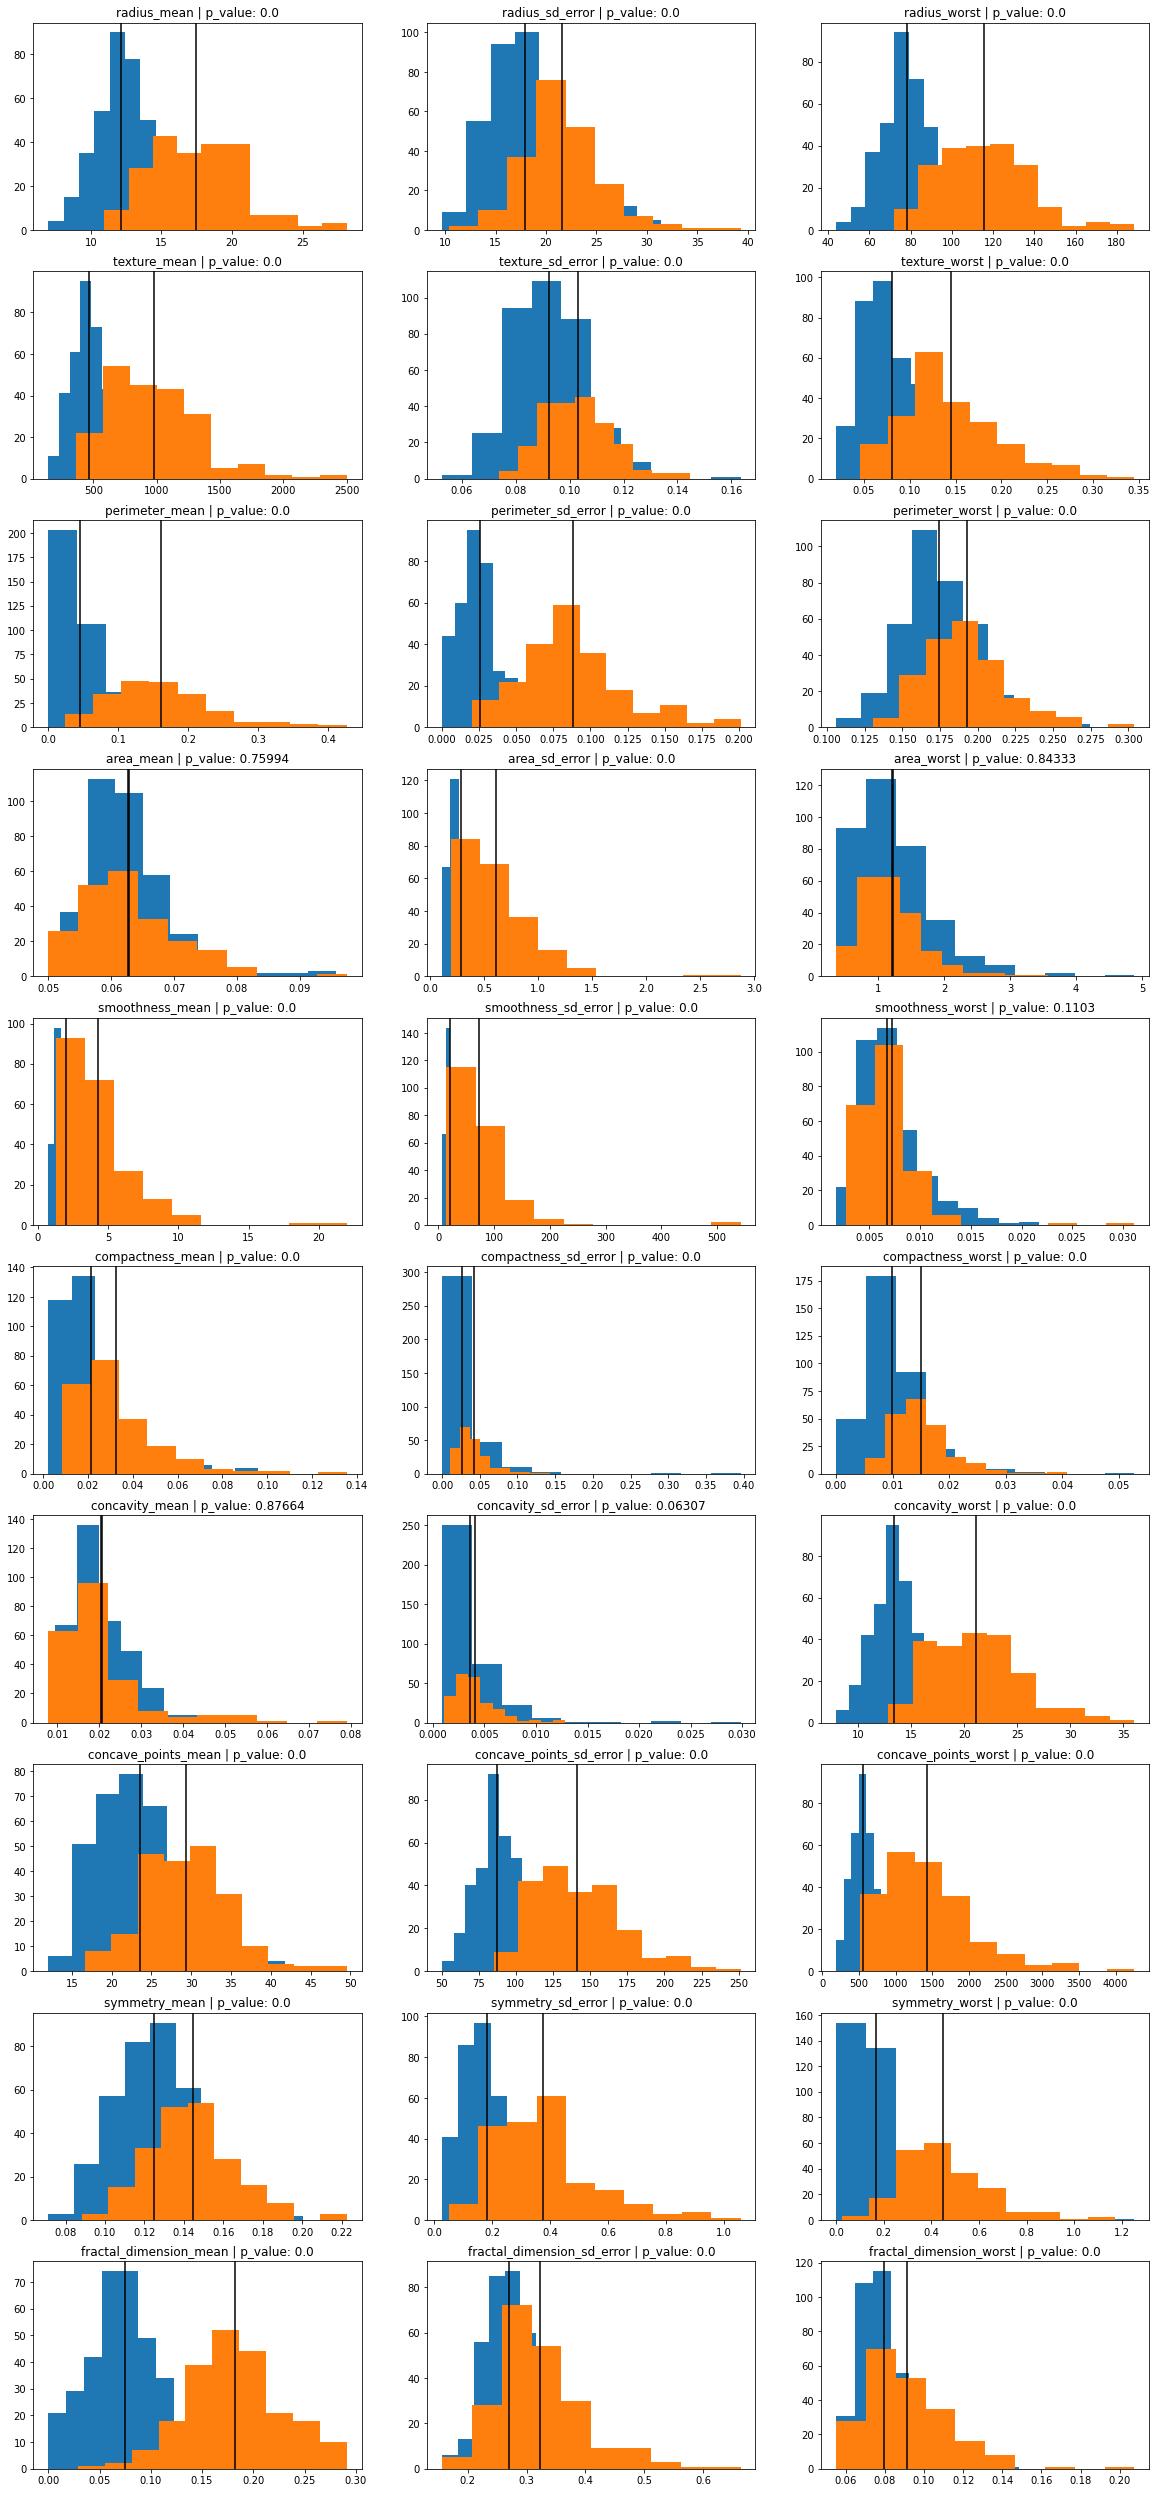

In [ ]:
# plot histograms of each class for each feature and a black line where each class mean is
fig, axs = plt.subplots(10,3,figsize=(20,45))
for row in range(10):
	for col in range(3):
		feature = all_columns[row*3+col]
		b = data.loc[data['diagnosis'] == 'B', feature]
		m = data.loc[data['diagnosis'] == 'M', feature]
		axs[row,col].hist(b)
		axs[row,col].hist(m)
		axs[row,col].axvline(b.mean(), color='k')
		axs[row,col].axvline(m.mean(), color='k')
		axs[row,col].set_title(f"{feature} | p_value: {t_tests.loc[t_tests.index==feature, 'p_value1'].values[0]}")
plt.show()

The p value in the above histograms comes from the t test.  We can compare the p value with how far the mean lines are apart from each other.  The three features mentioned above have the least distance between means, further validating that their means could come from the same population and may not be good features to use in modeling.  

Below we define a function so that we can oversample our minority class.  The test data is separated first, so that we don't oversample from it which would be data leakage.  From the remaining data, the minority class is oversampled to make it the same size as the majority class.

In [ ]:
# when bootstrapping to increase the minority class size, we must carefuly set the testing data aside, so that we don't have the same datapoint
# in both the training and testing set, which would be data leakage
def bootstrap_class(X, y, test_size=.3):
    df = X.merge(y, left_index=True, right_index=True)
    m = df.loc[df['diagnosis'] == 1]
    b = df.loc[df['diagnosis'] == 0]
    test_b = b.sample(frac=test_size, random_state=1001)
    test_size = len(test_b)
    test_m = m.sample(n=test_size, random_state=1001)
    train_size = len(b) - test_size
    minority_train = m.loc[~m.index.isin(test_m.index)]
    train_m = resample(minority_train, replace=True, n_samples=train_size, random_state=1001)
    train_b = b.loc[~b.index.isin(test_b.index)]
    train = pd.concat([train_b, train_m])
    test = pd.concat([test_b, test_m])
    y_train = train.pop('diagnosis')
    y_test = test.pop('diagnosis')
    return train, test, y_train, y_test

In [ ]:
# scale the features, fitting on only the training data to prevent leakage, then transforming the training and testing data.
scaler = MinMaxScaler()
def scale_data(X_train, X_test):
	train_index = X_train.index
	test_index = X_test.index
	X_train = scaler.fit_transform(X_train)
	X_test = scaler.transform(X_test)
	X_train = pd.DataFrame(X_train, columns=columns, index=train_index)
	X_test = pd.DataFrame(X_test, columns=columns, index=test_index)
	return X_train, X_test

In [ ]:
# split data for training and testing
if bootstrap_imbalance:
	X_train, X_test, y_train, y_test = bootstrap_class(X, y)
	X_train, X_test = scale_data(X_train, X_test)
	if save_data and X_train.columns == 30:
		X_train.to_csv(f'{os.getcwd()}/data/X_train_boot.csv')
		X_test.to_csv(f'{os.getcwd()}/data/X_test_boot.csv')
		y_train.to_csv(f'{os.getcwd()}/data/y_train_boot.csv')
		y_test.to_csv(f'{os.getcwd()}/data/y_test_boot.csv')
else:
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1001)
	X_train, X_test = scale_data(X_train, X_test)
	if save_data and X_train.columns == 30:
		X_train.to_csv(f'{os.getcwd()}/data/X_train.csv')
		X_test.to_csv(f'{os.getcwd()}/data/X_test.csv')
		y_train.to_csv(f'{os.getcwd()}/data/y_train.csv')
		y_test.to_csv(f'{os.getcwd()}/data/y_test.csv')

In [ ]:
# plot feature importance for xgboost
def plot_feature_imp(model, features):
	imp_score = pd.DataFrame(model.feature_importances_, columns=['Importance Score'])
	features = pd.DataFrame(features, columns=['Features'])
	feature_imp = pd.concat([features, imp_score], axis=1)
	feature_imp = feature_imp.sort_values(by='Importance Score', ascending=False).reset_index()
	features = feature_imp['Features'].tolist()
	print(feature_imp)
	print()
	ax = plt.figure(figsize=(15,10))
	ax = sns.barplot(x=feature_imp['Importance Score'], y=feature_imp['Features'])
	plt.savefig(f'{os.getcwd()}/feat_graphs/{file_name}.png')
	plt.show()

In [ ]:
# build and train logistic regression
if model_type == 'lr':

    X_train = pd.DataFrame(X_train, columns=columns)
    X_test = pd.DataFrame(X_test, columns=columns)

    lr = LogisticRegression()

    lr_params = {
    'penalty': ['l1', 'l2'],
    'dual': [True, False],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['liblinear', 'saga'],
    }

    lr_random_search = RandomizedSearchCV(lr, param_distributions=lr_params, n_jobs=-1, random_state=1001, refit=True)

    lr_random_search.fit(X_train, y_train)
    model = lr_random_search.best_estimator_

    print('Training accuracy:', model.score(X_train, y_train))
    print('Test accuracy:', model.score(X_test, y_test))
    print(file_name)
    pickle.dump(model, open(f"{os.getcwd()}/models/{file_name}.pickle.dat", "wb"))
    print("Successfully saved model in models folder!")

In [ ]:
# calculate information values for features
def iv_woe(data, target, bins=10, show_woe=False):

    #Empty Dataframe
    newDF = pd.DataFrame()

    #Extract Column Names
    cols = data.columns

    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = d['Events'] / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = d['Non-Events'] / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars],
                            "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)

        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF

data_iv = data
data_iv['diagnosis'] = data_iv['diagnosis'].replace({'B': 0, 'M': 1})
IV_Table = iv_woe(data = data, target = 'diagnosis', bins=10, show_woe = False)
IV_Table = IV_Table.set_index('Variable')
# Taken from https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html

Information value of radius_mean is inf
Information value of radius_sd_error is 1.287501
Information value of radius_worst is inf
Information value of texture_mean is inf
Information value of texture_sd_error is 0.772938
Information value of texture_worst is 2.263086
Information value of perimeter_mean is inf
Information value of perimeter_sd_error is inf
Information value of perimeter_worst is 0.622102
Information value of area_mean is 0.259552
Information value of area_sd_error is inf
Information value of area_worst is 0.096284
Information value of smoothness_mean is inf
Information value of smoothness_sd_error is inf
Information value of smoothness_worst is 0.083823
Information value of compactness_mean is 0.920717
Information value of compactness_sd_error is inf
Information value of compactness_worst is 1.363931
Information value of concavity_mean is 0.090338
Information value of concavity_sd_error is 0.256794
Information value of concavity_worst is inf
Information value of concave

In [ ]:
# add information value to statistical test dataframe for further comparison
final_stats_df = compare_means.merge(IV_Table, left_index=True, right_index=True)
final_stats_df

,t_stat,p_value1,stat,p_value2,IV
radius_mean,25.43582,0.00000,70955.0,0.00000,inf
radius_sd_error,10.86720,0.00000,58717.5,0.00000,1.287501
radius_worst,26.40521,0.00000,71665.0,0.00000,inf
texture_mean,23.93869,0.00000,71015.5,0.00000,inf
texture_sd_error,9.14610,0.00000,54647.0,0.00000,0.772938
texture_worst,17.69839,0.00000,65374.5,0.00000,2.263086
perimeter_mean,23.10396,0.00000,70978.5,0.00000,inf
perimeter_sd_error,29.35432,0.00000,72992.5,0.00000,inf
perimeter_worst,8.33831,0.00000,52870.0,0.00000,0.622102
area_mean,-0.30571,0.75994,36671.5,0.53719,0.259552


Looking at the features with the highest information values, it can be noted that they also have the lowest p values and are within the highest t-stats and Mann Whitney U test statistics.  To identify which three features are predictive of a malignant tumor, we can combine the information from the histograms, the p values, the test statistics, the information value and the importance score as specified by our xgboost model.  We will go forward with 'concave_points_sd_error', 'concavity_worst' and 'perimeter_sd_error'.  These features are the top three most important according to our xgboost importance score, which have some of the largest distances between means which can be seen on our histograms. These features also have close to zero p values, are within the highest values of the test statistics, and have the highest information values.  All of these values can be seen in our final_stats_df above.

In [ ]:
# build and train xgboost classification
if model_type == 'xgb':

    model = xgb.XGBClassifier(eval_metric='logloss', n_estimators=600,
    objective='binary:logistic', tree_method='gpu_hist')
    params = {
    'min_child_weight': [1, 5, 7.5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [.01, .02, .05, .1, .15, .2]
    }
    
    random_search = RandomizedSearchCV(model, param_distributions=params, scoring='roc_auc', n_jobs=-1,
    verbose=5, random_state=1001, refit=True)
    
    random_search.fit(X_train, y_train)
    model = random_search.best_estimator_
    plot_feature_imp(model, columns)
    
    model.set_params(tree_method='hist')
    
    print('Training accuracy:', model.score(X_train, y_train))
    print('Test accuracy:', model.score(X_test, y_test))
    print(file_name)
    pickle.dump(model, open(f"{os.getcwd()}/models/{file_name}.pickle.dat", "wb"))
    print("Successfully saved model in models folder!")

In [ ]:
# validate models
directory_files = os.listdir('models')
models = [x for x in directory_files if x[-3:] == 'dat']
models

['logloss_roc-auc_scaled_2feats.pickle.dat',
 'logloss_roc-auc_scaled_2feats_boot.pickle.dat',
 'logloss_roc-auc_scaled_3feats.pickle.dat',
 'logloss_roc-auc_scaled_3feats_boot.pickle.dat',
 'logloss_roc-auc_scaled_allfeats.pickle.dat',
 'logloss_roc-auc_scaled_allfeats_boot.pickle.dat',
 'lr_accuracy_scaled_2feats.pickle.dat',
 'lr_accuracy_scaled_2feats_boot.pickle.dat',
 'lr_accuracy_scaled_3feats.pickle.dat',
 'lr_accuracy_scaled_3feats_boot.pickle.dat',
 'lr_accuracy_scaled_allfeats.pickle.dat',
 'lr_accuracy_scaled_allfeats_boot.pickle.dat']

In [ ]:
# calculate and gather validation metrics
metrics = [accuracy_score, precision_score, recall_score, f1_score]
train_metrics_dict = {}
test_metrics_dict = {}
for model in models:
	load = pickle.load(open(f"{os.getcwd()}/models/" + model, "rb"))
	if 'boot' in model:
		X_train_load = pd.read_csv(f"{os.getcwd()}/data/X_train_boot.csv", index_col=0)
		y_train_load = pd.read_csv(f"{os.getcwd()}/data/y_train_boot.csv", index_col=0)
		X_test_load = pd.read_csv(f"{os.getcwd()}/data/X_test_boot.csv", index_col=0)
		y_test_load = pd.read_csv(f"{os.getcwd()}/data/y_test_boot.csv", index_col=0)
		if '2' in model:
			X_train = X_train_load[['concave_points_sd_error', 'concavity_worst']]
			X_test = X_test_load[['concave_points_sd_error', 'concavity_worst']]
		elif '3' in model:
			X_train = X_train_load[['concave_points_sd_error', 'concavity_worst', 'perimeter_sd_error']]
			X_test = X_test_load[['concave_points_sd_error', 'concavity_worst', 'perimeter_sd_error']]
		else:
			X_train = X_train_load
			X_test = X_test_load
	else:
		X_train_load = pd.read_csv(f"{os.getcwd()}/data/X_train.csv", index_col=0)
		y_train_load = pd.read_csv(f"{os.getcwd()}/data/y_train.csv", index_col=0)
		X_test_load = pd.read_csv(f"{os.getcwd()}/data/X_test.csv", index_col=0)
		y_test_load = pd.read_csv(f"{os.getcwd()}/data/y_test.csv", index_col=0)
		if '2' in model:
			X_train = X_train_load[['concave_points_sd_error', 'concavity_worst']]
			X_test = X_test_load[['concave_points_sd_error', 'concavity_worst']]
		elif '3' in model:
			X_train = X_train_load[['concave_points_sd_error', 'concavity_worst', 'perimeter_sd_error']]
			X_test = X_test_load[['concave_points_sd_error', 'concavity_worst', 'perimeter_sd_error']]
		else:
			X_train = X_train_load
			X_test = X_test_load
	y_pred1 = load.predict(X_train)
	y_pred2 = load.predict(X_test)
	y_train = y_train_load
	y_test = y_test_load
	ax = plt.figure(figsize=(15,10))
	conf_mat = confusion_matrix(y_test, y_pred2)
	ax = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
	plt.savefig(f'{os.getcwd()}/feat_graphs/{model}_con_mat.png')
	train_metrics_dict[model] = []
	test_metrics_dict[model] = []
	for metric in metrics:
		train_metrics_dict[model].append(metric(y_train, y_pred1))
		test_metrics_dict[model].append(metric(y_test, y_pred2))

[20:39:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:223: No visible GPU is found, setting `gpu_id` to -1
[20:39:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:223: No visible GPU is found, setting `gpu_id` to -1
[20:39:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:223: No visible GPU is found, setting `gpu_id` to -1
[20:39:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:223: No visible GPU is found, setting `gpu_id` to -1
[20:39:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:223: No visible GPU is found, setting `gpu_id` to -1
[20:39:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:223: No visible GPU is found, setting `gpu_id` to -1


<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

In [ ]:
# all test metrics in df below
final_names = [x[:-11].replace('logloss_roc-auc_scaled', 'xgb').replace('accuracy_scaled_', '') for x in models]
final_test_df = pd.DataFrame(test_metrics_dict, index=['accuracy', 'precision', 'recall', 'f1'])
final_test_df.columns = final_names
final_test_df

,xgb_2feats,xgb_2feats_boot,xgb_3feats,xgb_3feats_boot,xgb_allfeats,xgb_allfeats_boot,lr_2feats,lr_2feats_boot,lr_3feats,lr_3feats_boot,lr_allfeats,lr_allfeats_boot
accuracy,0.918129,0.892523,0.923977,0.920561,0.970760,0.943925,0.912281,0.915888,0.935673,0.925234,0.970760,0.976636
precision,0.950820,0.920000,0.911765,0.916667,0.984848,0.952381,0.935484,0.915888,0.914286,0.917431,0.984848,0.990385
recall,0.840580,0.859813,0.898551,0.925234,0.942029,0.934579,0.840580,0.915888,0.927536,0.934579,0.942029,0.962617
f1,0.892308,0.888889,0.905109,0.920930,0.962963,0.943396,0.885496,0.915888,0.920863,0.925926,0.962963,0.976303


In [ ]:
# all train metrics in df below
final_train_df = pd.DataFrame(train_metrics_dict, index=['accuracy', 'precision', 'recall', 'f1'])
final_train_df.columns = final_names
final_train_df

,xgb_2feats,xgb_2feats_boot,xgb_3feats,xgb_3feats_boot,xgb_allfeats,xgb_allfeats_boot,lr_2feats,lr_2feats_boot,lr_3feats,lr_3feats_boot,lr_allfeats,lr_allfeats_boot
accuracy,0.944724,0.986000,0.949749,0.982000,1.0,1.0,0.917085,0.900000,0.939698,0.946000,0.984925,0.984000
precision,0.941606,0.980237,0.942446,0.976285,1.0,1.0,0.892857,0.920168,0.934307,0.947791,0.992806,0.980159
recall,0.902098,0.992000,0.916084,0.988000,1.0,1.0,0.874126,0.876000,0.895105,0.944000,0.965035,0.988000
f1,0.921429,0.986083,0.929078,0.982107,1.0,1.0,0.883392,0.897541,0.914286,0.945892,0.978723,0.984064


In this notebook we have used two classification techniques: xgboost and logistic regression.  Both models have their advantages and disadvantages.  xgboost requires more tuning and a larger grid or randomized search of parameters to obtain similar results.  Because of this, it was a bit slower than logistic regression, even though it could utilize a GPU and is known to be a faster algorithm than other model types such as a random forest style process.  Training duration was not significant in this exercise, but would be with hundreds of thousands of data points. Because of the success of xgboost models in the past, the lesser performance in this case might be attributed to a lack of data, but this also might not be the case. A disadvantage of logistic regression is that it has poor performance on non-linear problems because it has a linear decision surface (https://www.geeksforgeeks.org/advantages-and-disadvantages-of-logistic-regression/). On the contrary, xgboost trees can be very complex and are able to model non-linear relationships.

In all types of models, overfitting is a problem.  We know that our models are likely not overfit because of the high test accuracy that's been achieved. For logistic regression, adding different penalties such as l1 or l2 to our randomized search will prevent overfitting. This may reduce our training accuracy, but using the randomized search will maximize the scoring metric after cross validating, and if the test scoring is good, then it provides significant evidence that the model is not overfit. The same applies to the regularization paramater or solver, which will make the predictions more general and prevent overfitting. For xgboost, we can set the max depth, which splits the branches and then starts pruning backwards.  Using a few different values in our randomized search will again help control overfitting, because it will pick the max depth that optimizes the scoring metric after cross validation. Max depth is only the most obvious parameter for xgboost, and several others in the randomized search will also help control overfitting like determining when a further partition of a leaf node is required or not (gamma).

For each model, the most predictive variables are similar, but not exactly the same.  With xgboost it is easy to identify the most predictive variables, because the feature importance method can simply be called after training with all variables.  With logistic regression, a separate library was imported to calculate information values for each variable. Before proceeding with any variables, each chosen predictive variable was checked with test statistics and p values. Note that some information values are infinite, but these also have the best test statistics and p values.

Explanations:

Technical Audience:  
The limitations of this analysis include the fact that this is a very small sample, and it may not be random enough to have created a model that can generalize to the entire population. There could be two problems identified here: the first is that new measurements are within the range of the training measurements, but they don't have the same relationships amongst themselves (inter variable relationship). The second is that new measurements might have values more extreme (higher or lower) than our training data has seen, and the model might not extrapolate well to identify these. Furthermore, we have no metadata describing the accuracy of the measurements collected, or if these measurements change much between different collection instruments. Further steps to be taken would be to collect more data, try different modeling techniques, and try to optimize training using recall instead of accuracy or roc-auc.  Another avenue that could be explored is creating principal components of the features, and testing how many components are optimal.  This could be performed through a principal components analysis (PCA), to capture the axes of greatest variation, or a linear discriminant analysis (LDA), to capture the components that separate the class labels the best.  Because this classification is binary, we are attempting to identify the positive class. This means that accuracy will not be our best evaluation metric. Because of class imbalance in real world data, the accuracy metric will not always provide an accurate success value of the model.  If most occurences of tumors are benign, and the model predicts benign every time, we could still end up with good accuracy. The important metric in a malignant tumor identification is recall, and we want to maximize it. Even if we sacrifice a bit of our precision score, it is better to identify a benign tumor as malignant and have it checked by a doctor, than it is to miss a malignant tumor and label it as benign. Ideally, the model wouldn't miss a single positive instance. In conclusion, the logistic regression model actually performs the best and has the highest recall with the bootstrapped data.  xgboost actually performs worse on the bootstrapped data.

Non-Technical Audience:  
In this analysis, we have used conventional statistics and machine learning to build a model that will examine up to thirty different measured attributes of tumors, and predict whether a tumor is malignant or benign, based on the malignant and benign data it has been trained on. The factors that contribute to a malignant vs a benign tumor can be identified by the average measurements of each class and how different they are. For example, if the average radius of a malignant tumour is quite similar to that of a benign tumor, this feature likely has very low predictive power because we won't be able to tell the difference easily. We want to identify feature values that are unique to each class (M and B). Upon looking at the above histograms, it can be seen that for all features, malignant values are usually greater than benign values, and if not greater, they are similar. It can also be noted that the malignant values are rarely less than the benign values, signifying that the greater the tumor size is, the more likely that it is malignant. Regardless of feature difference, both styles of model that we built predict better when using all of the features. This is likely due to the fact that in certain cases, datapoints may have quite similar values in the more predictive features, and rely on another feature to make the final decision.